In [146]:
import math, random, sys
import numpy as np
import matplotlib.pyplot as plt

### Period finder
Given a long lightcurve, single band or multiband, we can explore if there is a periodic component.
Uses the Conditional Entopy method of [Graham++](https://academic.oup.com/mnras/article/434/3/2629/1044188).
Numpy implementation influenced by [Lauffer](https://github.com/glauffer/Conditional-Entropy/blob/master/conditional_entropy.py)

In [147]:
# First make a sine wave with noise as a trial lightcurve
def fake_lightcurve(npoints, period, noise):
    data = []
    it = 0
    for i in range(npoints):
        it += random.randrange(2,6)
        t = it + random.random()/3
        y = math.sin(2*3.14158*t/period) + noise*random.random()
        data.append([t, y])
    return np.array(data)

In [148]:
# divide the time of observations by the period
def get_phase(time, period, shift=0.0):
    return (time / period - shift) % 1

#  Here we transform the time of observations to the phase space
def rephase(data, period, shift=0.0, col=0, copy=True):
    rephased = np.ma.array(data, copy=copy)
    rephased[:, col] = get_phase(rephased[:, col], period, shift)
    return rephased

# Normalize the lightcurve between 0 and 1
def normalization(data):
    norm = np.ma.copy(data)
    norm[:,1] = (norm[:,1] - np.min(norm[:,1])) \
        / (np.max(norm[:,1]) - np.min(norm[:,1]))

    return norm

### Evaluate conditional entropy for given period

In [149]:
def cond_entropy(period, data, p_bins=10, m_bins=5):
    if period <= 0:
        return np.PINF
    ndata = normalization(data)
    r = rephase(ndata, period)
    bins, *_ = np.histogram2d(r[:,0], r[:,1], [p_bins, m_bins],
                                [[0,1], [0,1]])
    size = r.shape[0]
    if size > 0:
        divided_bins = bins / size
        arg_positive = divided_bins > 0
        column_sums = np.sum(divided_bins, axis=1) #change 0 by 1
        column_sums = np.repeat(np.reshape(column_sums,(p_bins,1)), m_bins, axis=1)

        select_divided_bins = divided_bins[arg_positive]
        select_column_sums  = column_sums[arg_positive]

        A = np.empty((p_bins, m_bins), dtype=float)
        A[ arg_positive] = select_divided_bins \
                         * np.log(select_column_sums / select_divided_bins)
        A[~arg_positive] = 0
        return np.sum(A)
    else:
        return np.PINF

### Now we do a test run
The period is 250 days, with 10% noise on the sine wave

In [150]:
npoints      = 1000
real_period  = 250  # days
noise        = 0.1 # compared to amplitude
data = fake_lightcurve(npoints, real_period, noise)

#### Plot the fake lightcurve

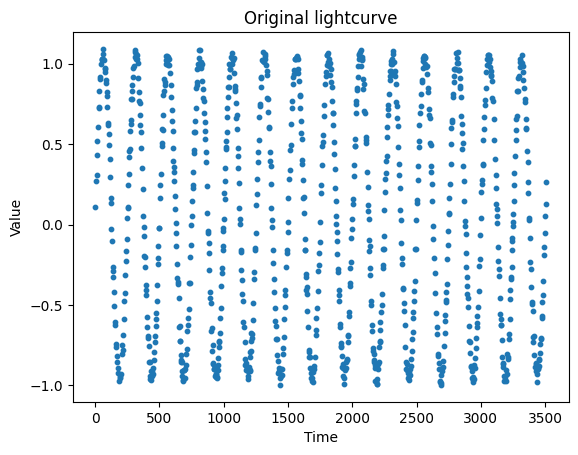

In [151]:
plt.scatter(data[:,0], data[:,1], s=10)
plt.title('Original lightcurve')
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

Here we look at the folded lightcurve when we are very close to the correct period. 
First as a scatter plot, then as a 2D histogram from which the CE is computed.

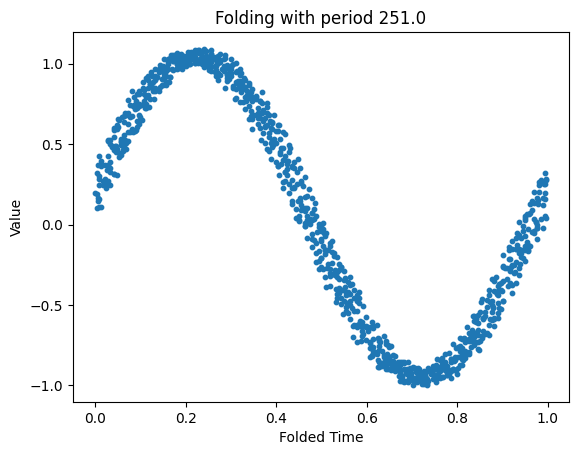

In [152]:
def plotfold(data, period):
    rdata = rephase(data, period)
    plt.scatter(rdata[:,0], rdata[:,1], s=10)
    plt.title('Folding with period %.1f' % period)
    plt.xlabel("Folded Time")
    plt.ylabel("Value")
    plt.show()

period = 251
plotfold(data, period)

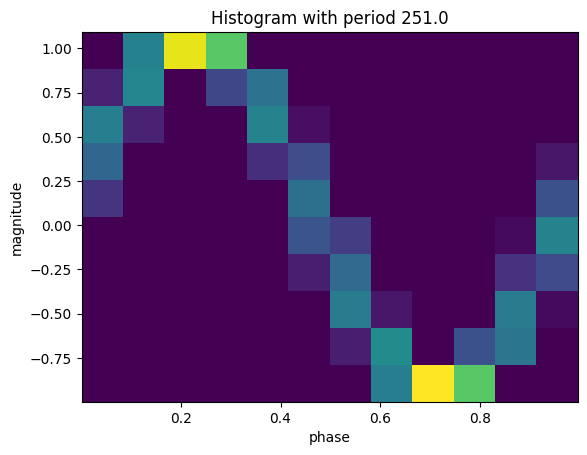

In [153]:
def plothist(data, period, p_bins=10, m_bins=5):
    rdata = rephase(data, period)
    ndata = normalization(rdata)
    plt.hist2d(rdata[:, 0], rdata[:, 1], bins=(p_bins,m_bins))
    plt.title('Histogram with period %.1f' % period)
    plt.xlabel('phase')
    plt.ylabel('magnitude')
    plt.show()

p_bins=12
m_bins=10
plothist(data, period, p_bins, m_bins)

From this histogram with $m_i$ bins in magnitude and $p_i$ bins in phase, 
the conditional entropy is $$ H_c = \sum_{i, j} {p(m_i, \phi_j) \ln \frac {p(\phi_j)}{p(m_i, \phi_j)}}$$

#### Minimise the CE to get the period

In [154]:
# A range of periods to try, from 200 to 600 days
min_period = 50
max_period = 450
n_period   = 400
periods = []
for i in range(n_period):
    periods.append(min_period + i*(max_period-min_period)/n_period)

In [155]:
# Now compute the CE for each period
ce = []
for period in periods:
    ce_value = cond_entropy(period, data, p_bins=p_bins, m_bins=m_bins)
    ce.append(ce_value)
    imin = np.argmin(ce)
period = periods[imin]
min_entropy = ce[imin]

imax= np.argmax(ce)
max_entropy = ce[imax]
rat = min_entropy/max_entropy
if rat < 0.6:
    print('Entropy ratio for period %.2f is %.3f' % (period, rat))

Entropy ratio for period 250.00 is 0.314


#### Plot CE as a function of period

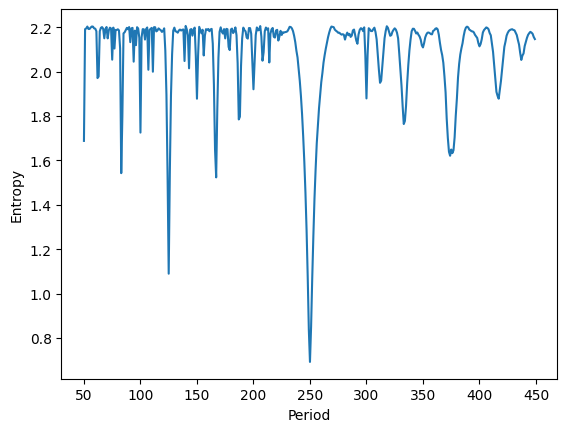

In [156]:
plt.plot(periods, ce)
plt.xlabel("Period")
plt.ylabel("Entropy")
plt.show()

### Some real lightcurves from ZTF

ZTF18abcpzmr period 55.00 is 0.883
ZTF20aapgguv period 106.00 is 0.922
ZTF18abujecs period 230.00 is 0.851
ZTF19aakkixu period 52.00 is 0.727
ZTF21aaupuzv period 111.00 is 0.957
ZTF24aaujiap period 52.00 is 0.944
ZTF18abxvnkr period 300.00 is 0.915
ZTF18abgspty period 88.00 is 0.906
ZTF18aboawru period 279.00 is 0.726
ZTF21aaznqgi period 54.00 is 0.876
ZTF19abjilfe period 261.00 is 0.835
ZTF18abifynq period 309.00 is 0.773
ZTF18abcnmcp period 68.00 is 0.833
ZTF20aazzlyg period 292.00 is 0.871
ZTF23abnunis period 63.00 is 0.829
ZTF21aaloqjq period 341.00 is 0.728
ZTF20aafbamj period 60.00 is 0.867
ZTF20abztoud period 59.00 is 0.937
ZTF19aaimihg period 130.00 is 0.543


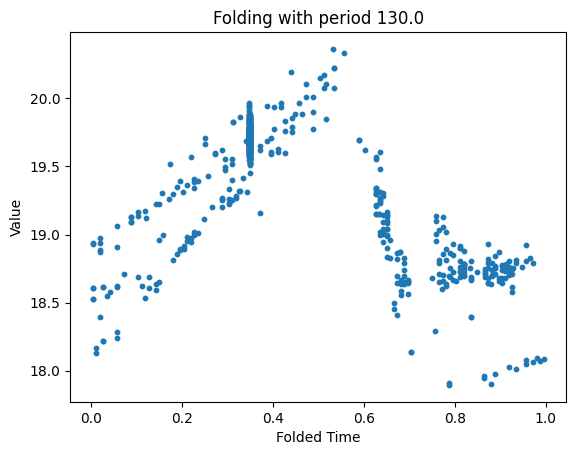

ZTF18acesvtd period 67.00 is 0.914
ZTF18adryvwr period 77.00 is 0.931
ZTF21aavrglo period 116.00 is 0.792
ZTF19admnhzt period 77.00 is 0.970
ZTF19aclxler period 173.00 is 0.920
ZTF18abvoabk period 335.00 is 0.908
ZTF23aapvhsp period 77.00 is 0.946
ZTF22aahnmtr period 84.00 is 0.763
ZTF18abliihj period 132.00 is 0.924
ZTF18accegho period 243.00 is 0.701
ZTF18abifybs period 77.00 is 0.919
ZTF18acgljhz period 50.00 is 0.878
ZTF19acuyuol period 90.00 is 0.834
ZTF18acarpxd period 308.00 is 0.863
ZTF19aaimmak period 428.00 is 0.789
ZTF18acvnnov period 55.00 is 0.932
ZTF19acyvkrb period 55.00 is 0.869
ZTF18accefjt period 166.00 is 0.705
ZTF18adkcmku period 147.00 is 0.542


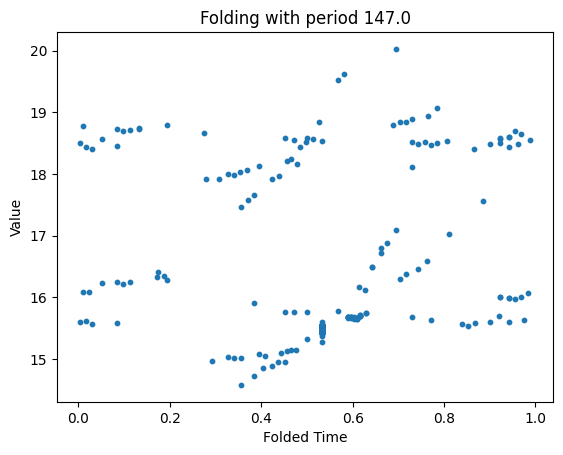

ZTF18adjzovd period 63.00 is 0.757
ZTF20abayxsn period 55.00 is 0.959
ZTF21aakwnvm period 183.00 is 0.715
ZTF19acjnnwr period 50.00 is 0.878
ZTF18abebezz period 67.00 is 0.906
ZTF18adkcmat period 135.00 is 0.779
ZTF19adhjurf period 102.00 is 0.844
ZTF18adkbaza period 197.00 is 0.727
ZTF24aabbuox period 63.00 is 0.844
ZTF18abfjvlz period 201.00 is 0.481


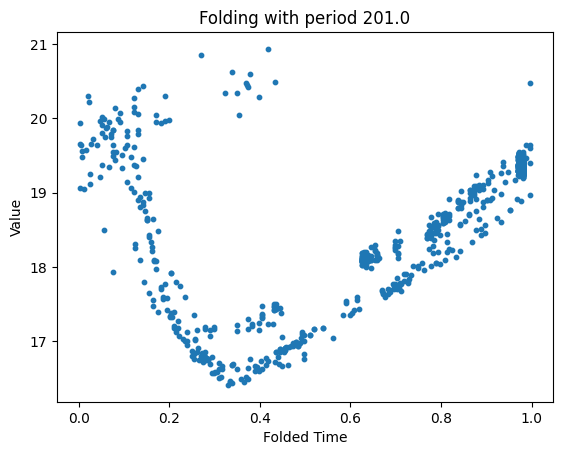

ZTF24aatylwq period 53.00 is 0.078


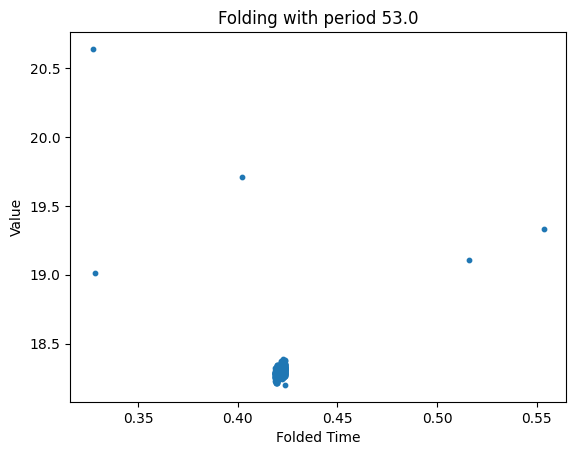

ZTF18abahtbe period 231.00 is 0.795
ZTF18abfiojd period 127.00 is 0.537


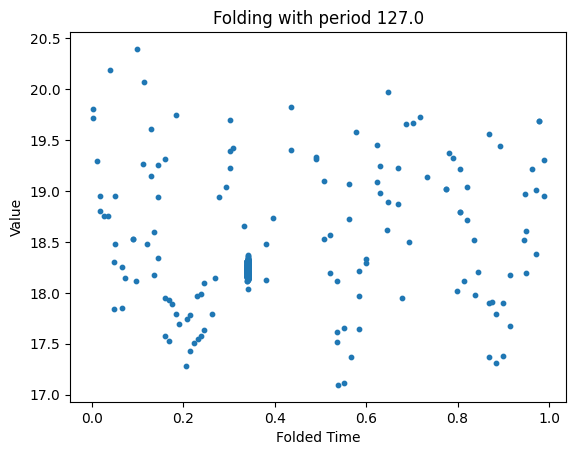

ZTF19adcnlms period 212.00 is 0.868
ZTF20acvflgh period 95.00 is 0.644
ZTF18aazmehi period 69.00 is 0.956
ZTF18abzhlay period 67.00 is 0.850
ZTF18ablliyk period 444.00 is 0.789
ZTF19aatqhxd period 81.00 is 0.952


In [157]:
import lasair
import settings
L = lasair.lasair_client(settings.API_TOKEN, cache='cache')
selected = 'objects.objectId, sherlock_classifications.classification as class'
tables = 'objects,sherlock_classifications'
conditions = 'ncandgp>300'
max_alert = 100
results = L.query(selected, tables, conditions, limit=max_alert)
for row in results:
    objectId = row['objectId']
    alert = L.objects([objectId])[0]
# for ZTF, the candidates and noncandiates are mixed in, and the noncandidates have no candid
    sources  = [c for c in alert['candidates'] if 'candid' in c]
    data = []
    for i in range(len(sources)):
        data.append([sources[i]['mjd'], sources[i]['magpsf']])
    ce = []
    for period in periods:
        ce_value = cond_entropy(period, np.array(data), p_bins=p_bins, m_bins=m_bins)
        ce.append(ce_value)

    imin = np.argmin(ce)
    period = periods[imin]
    imax= np.argmax(ce)
    rat = ce[imin]/ce[imax]
    print('%s period %.2f is %.3f' % (objectId, period, rat))
    if rat < 0.6:
        plotfold(data, period)